In [26]:
import numpy as np
from matplotlib    import pyplot as plt
from numpy.random  import default_rng
from tqdm          import tqdm
from time          import perf_counter 
from scipy.stats   import rice, foldnorm
from dw_tools      import dag_pgm_tools, draw_tree
import networkx 
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import reciprocalspaceship as rs
import gemmi

In [2]:
plt.rcParams.update({'font.size': 14})
%load_ext autoreload
%autoreload 2

## Taking a "tree" point of view...
Consider three complex structure factors $F_1$,$F_2$,$F_3$, such that 
<img src="img/F1_F2_F3.png" alt="drawing" width="200"/>
for example
<img src="img/ref_off_on.png" alt="drawing" width="200"/>

with arrows indicating statistical dependence, parameterized by a DW parameter indicated by the superscripts (note that correlations are equal in both directions). With this scheme, the graph has the structure of a directed acyclic graph (DAG), or more specifically, a tree, or yet more specifically, an arborescence (see https://en.wikipedia.org/wiki/Arborescence_(graph_theory)).

For the remainder, we will assume that the structure factors live on a common scale set by $\Sigma=\mathbb{E}(|F|^2)$. To indicate this, we'll switch from $F$ to $E$. We'll keep the common scale $\Sigma$ around, noting that for normalized structure factors $\Sigma=1$.

We can think of $E_2$ as consisting of 
- a chunk $r E_1$, with variance $r^2 \frac{\Sigma}{2}$ for real and imag components and,
- an independent bivariate normal chunk $\Delta_{21}$ with mean $(0,0)$ and covariance matrix $\frac{1}{2}(1-r^2)\Sigma \mathbf{I}$, 

with $\mathbf{I}$ the identity matrix. Now, $Var(E_{2x})=r^2 \frac{\Sigma}{2}+\frac{\Sigma}{2}(1-r^2)=\frac{\Sigma}{2}$. An analogous relationship applies to $E_3$ and $E_2$.

### Covariance matrix
Because of the conditional independence implied by these diagrams, the correlations of their amplitudes satisfy 

$$\rho\left( |E_1|, |E_3|\right)  = \rho\left( |E_1|, |E_2| \right)\cdot\rho\left( |E_2|, |E_3| \right).$$ 
Likewise, $$\rho\left(E_{1x}, E_{3x}\right) = \rho\left(E_{1y}, E_{2y}\right)\cdot\rho\left(E_{2x}, E_{3x}\right), \mathrm{etc.}$$

We can, hence, construct the covariance matrix as:

$$
C = \frac{\Sigma}{2}
\begin{bmatrix}
1      & r   & r_x r & 0     & 0   & 0      \\
r      & 1   & r_x   & 0     & 0   & 0      \\
r_x r  & r_x & 1     & 0     & 0   & 0      \\
0      & 0   & 0     & 1     & r   & r_x r  \\
0      & 0   & 0     & r     & 1   & r_x    \\
0      & 0   & 0     & r_x r & r_x & 1  
\end{bmatrix}
$$

with, again, for normalized structure factors, $\Sigma=1$. Note that this covariance matrix differs from what we used in notebooks **6_Bivariate_conditional_amplitude_phase_dists.ipynb** and its abbreviated versions, because we make a different assumption about their statistical dependence.

Conditional on $E_1$, we get:

$$
C_{(2,3)|1} = \frac{\Sigma}{2}
\begin{bmatrix}
1-r^2      & r_x(1-r^2) & 0          & 0          \\
r_x(1-r^2) & 1-r_x^2r^2 & 0          & 0          \\
0          & 0          & 1-r^2      & r_x(1-r^2) \\
0          & 0          & r_x(1-r^2) & 1-r_x^2r^2 \\ 
\end{bmatrix}
$$

which follows from the usual properties of conditioning for a multivariate normal (https://en.wikipedia.org/wiki/Multivariate_normal_distribution).

We also need

$$
C_{2|1} = 
\frac{\Sigma}{2}
\begin{bmatrix}
1-r^2  &     0    \\
0      & 1-r^2    \\
\end{bmatrix}
\ \  \mathrm{and} \ \ 
C_{3|2} = 
\frac{\Sigma}{2}
\begin{bmatrix}
1-r_x^2  &     0    \\
0      & 1-r_x^2    \\
\end{bmatrix}
$$

#### example calculations...

In [3]:
rng  = default_rng()
r    = 0.9
rx   = 0.5
R1   = np.asarray([1.5,1.5,0,0])       # unconditional: value of R1 (organized as E_2x,E_3x,E_2y,E_3y)
mean = np.array([r,r*rx,r,r*rx])*R1    # conditional means of components of E2 and E3
cov  = 0.5*\
    np.asarray([[ 1-r**2    , rx*(1-r**2),  0,           0          ],\
                [rx*(1-r**2), 1-rx**2*r**2, 0,           0          ],\
                [0,           0,            1 -r**2,     rx*(1-r**2)],\
                [0,           0,            rx*(1-r**2), 1-rx**2*r**2]])

In [4]:
n_samples = 10000000
vals   = rng.multivariate_normal(mean,cov,n_samples)
R2_sq  = vals[:,0]**2 + vals[:,2]**2
R3_sq  = vals[:,1]**2 + vals[:,3]**2
R2_abs = np.sqrt(R2_sq)
R3_abs = np.sqrt(R3_sq)
# print(np.cov(np.transpose(vals)))
# print(cov)

Alternative construction of the same:

In [5]:
E_2x_sampled = r*   R1[0] + np.sqrt(0.5*(1-r**2)      )*np.random.normal(size=(n_samples,))
E_3x_sampled = r*rx*R1[1] + np.sqrt(0.5*(1-r**2*rx**2))*np.random.normal(size=(n_samples,))
E_2y_sampled = r*   R1[2] + np.sqrt(0.5*(1-r**2)      )*np.random.normal(size=(n_samples,))
E_3y_sampled = r*rx*R1[3] + np.sqrt(0.5*(1-r**2*rx**2))*np.random.normal(size=(n_samples,))

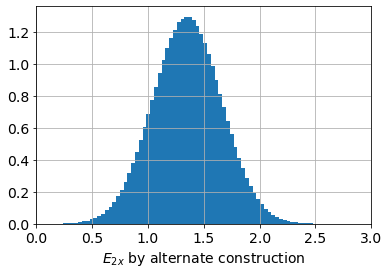

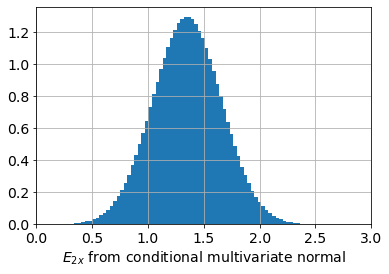

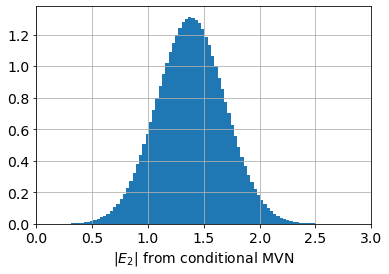

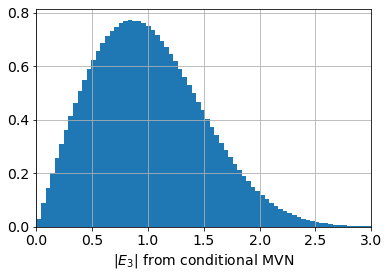

In [6]:
if True:
    plt.hist(E_2x_sampled,100,density=True)
    plt.xlabel(r"$E_{2x}$ by alternate construction")
    plt.xlim((0,3)); plt.grid(); plt.show()

    plt.hist(vals[:,0],100,density=True)
    plt.xlabel(r"$E_{2x}$ from conditional multivariate normal")
    plt.xlim((0,3)); plt.grid(); plt.show()

    plt.hist(R2_abs,100,density=True)
    plt.xlabel(r"$|E_{2}|$ from conditional MVN")
    plt.xlim((0,3)); plt.grid(); plt.show()

    plt.hist(R3_abs,100,density=True)
    plt.xlabel(r"$|E_{3}|$ from conditional MVN")
    plt.xlim((0,3)); plt.grid(); plt.show() # some graphical checks

### Factorizing the joint probability
The exciting thing about this formalism is that now 

$$
P\left(E_1,E_2,E_3\right) = 
P\left(E_3\bigr| E_2\right)\cdot
P\left(E_2\bigr| E_1\right) P\left(E_1\right)
=
P\left(R_3,\phi_3\bigr| R_2,\phi_2\right)\cdot
P\left(R_2,\phi_2\bigr| R_1,\phi_1\right)\cdot P\left(R_1,\phi_1\right)
$$

with $E_i=(R_i,\phi_i)$, etc. We already know that in the DW model $P\left(R_3,\phi_3\bigr| R_2\right)=P\left(R_3,\Delta\phi_{32}=\phi_3-\phi_2\bigr| R_2\right)$, etc., so now we have:

$$
P\left(E_2,E_3\bigr|E_1\right) = 
P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right)\cdot
P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) 
$$

so, when we integrate over the unknown phase differences, we get:

$$
P\left(R_2,R_3\bigr|E_1\right) = \int d\Delta\phi_{32} P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right)\cdot
                                 \int d\Delta\phi_{21} P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) 
$$


The results of _both_ integrals are Rice distributions. 

In our case, 

$$
\int d\Delta\phi_{32} P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right) = Rice\left(\nu = r_x R_2, \sigma^2 = \frac{\Sigma}{2}(1-r_x^2)\right)
$$
and
$$
\int d\Delta\phi_{21} P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) = Rice\left(\nu = r R_1, \sigma^2 = \frac{\Sigma}{2}(1-r^2)\right)
$$


#### Comparison to sampled data
Let's first examine this simple example, before moving to the general case:

In [7]:
def bivariate_Rice_DAG(R1, R2, R3, Sigma=1, r=r, rx=rx):
    cond_mean_21 = (R1 * r)
    cond_mean_32 = (R2 * rx)
    nu_21        = cond_mean_21
    nu_32        = cond_mean_32
    cond_var_21  = 0.5*Sigma*(1-r**2 )
    cond_var_32  = 0.5*Sigma*(1-rx**2)
    sigma_ac_21  = np.sqrt(cond_var_21)
    sigma_ac_32  = np.sqrt(cond_var_32)
    b_21         = nu_21/sigma_ac_21
    b_32         = nu_32/sigma_ac_32
    scale_21     = sigma_ac_21
    scale_32     = sigma_ac_32

    return rice.pdf(R3, b=b_32, scale=scale_32)*rice.pdf(R2, b=b_21, scale=scale_21)

In [8]:
nx, ny       = (200,300)
x_max, y_max = (5, 6)
xbase  = np.linspace(0.001, x_max, nx)
ybase  = np.linspace(0.001, y_max, ny)
xx,yy  = np.meshgrid(xbase, ybase)
print(xx.shape)
y_in   = np.transpose(np.array([np.transpose(xx).flatten(), np.transpose(yy).flatten()]))
print(y_in.shape)

t1_start = perf_counter()  
result = bivariate_Rice_DAG(R1[0], y_in[:,0].reshape(1,-1), y_in[:,1].reshape(1,-1), Sigma=1, r=r, rx=rx)
result = result.reshape(nx,ny)
print(result.shape)
t1_end = perf_counter()  

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result[:])*((x_max/nx)*(y_max/ny)):.3}")

(300, 200)
(60000, 2)
(200, 300)
Elapsed time: 0.0148 s
Integrated probability density: 0.992


We will compare this to the general solution implemented in ```dag_pgm_tools.RiceWoolfson_for_DAG``` and explained in the next section. To be able to do so, we need to summarize the properties of the graph underlying the PGM. Specifically,

In [9]:
list_of_nodes = [0,1,2]
list_of_edges = [(0,1),(1,2)]
root          = 0
list_of_rDW   = [r,rx]  # one element per edge
root_R        = R1[0]   # if we condition on the value of the root, we need to add this. 
                        # For unconditional PDF, use root_R=None

In [10]:
nx, ny       = (200,300)
x_max, y_max = (5, 6)
xbase  = np.linspace(0.001, x_max, nx)
ybase  = np.linspace(0.001, y_max, ny)
xx,yy  = np.meshgrid(xbase, ybase)
y_in   = np.transpose(np.array([np.transpose(xx).flatten(), np.transpose(yy).flatten()]))
print(xx.shape)
print(y_in.shape)

t1_start = perf_counter()  
result_2 = dag_pgm_tools.RiceWoolfson_for_DAG(list_of_nodes, list_of_edges, root=root, list_of_rDW=list_of_rDW, \
                                              root_R=root_R, root_rDW=None, Sigma=1, centric=False\
                                             ).prob(np.concatenate((np.zeros((y_in.shape[0],1)), y_in),axis=1))
result_2 = result_2.reshape(nx,ny)
# print(result_2.shape)
t1_end = perf_counter()  

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result_2[:])*((x_max/nx)*(y_max/ny)):.3}")

(300, 200)
(60000, 2)
Overwrote the 0th column with the reference.
Elapsed time: 0.0296 s
Integrated probability density: 0.992


Let's compare the bivariate and general PDFs to the samples:

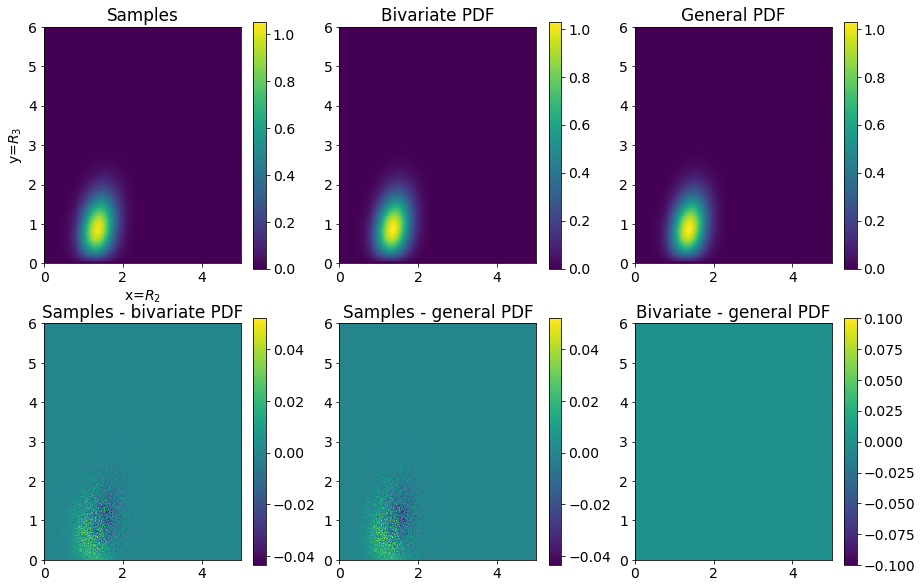

In [11]:
(xmax,ymax) = (x_max,y_max)
xedges = np.linspace(0,xmax,nx+1)
yedges = np.linspace(0,ymax,ny+1)
Hx_emp, xedges, yedges = np.histogram2d(R2_abs, R3_abs, bins=(xedges, yedges),density=True)

# Since the axes of these plots drive me a nuts, a positive control using [yplot.hist2d.
# In addition, I made the 2D histograms below asymmetric in dimension (remove "extent=[]" to see that),
# and validated labels using 1D histograms above.
# fig,ax=plt.subplots()
# ax.hist2d(R2_abs, R3_abs,bins=50,range=[[0,xmax],[0,ymax]])
# ax.set_aspect('equal')
# ax.set_xlabel(r"$R_2$"); ax.set_ylabel(r"$R_3$")
# plt.show()

plt.figure(figsize=(15,10))                         
plt.subplot(2,3,1)        
plt.imshow(Hx_emp.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) 
plt.xlabel(r"x=$R_2$"); plt.ylabel(r"y=$R_3$")
plt.title("Samples"); plt.colorbar(); 

plt.subplot(2,3,2)        
plt.imshow(result.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.title("Bivariate PDF"); plt.colorbar()

plt.subplot(2,3,3)        
plt.imshow(result_2.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.title("General PDF"); plt.colorbar()

plt.subplot(2,3,4)
plt.imshow((Hx_emp-result).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax])
plt.title("Samples - bivariate PDF"); plt.colorbar(); 

plt.subplot(2,3,5)
plt.imshow((Hx_emp-result_2).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax])
plt.title("Samples - general PDF"); plt.colorbar(); 

plt.subplot(2,3,6)
plt.imshow((result-result_2).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax])
plt.title("Bivariate - general PDF"); plt.colorbar(); plt.show()

We see that the synthetic data, ```bivariate_Rice_DAG``` and the general function ```dag_pgm_tools.RiceWoolfson_for_DAG.prob()``` yield consistent results.

### Specifying a general tree

Let's examine the joint PDF of the following graph, for example:
<img src="img/complex_dag_v1.png" alt="complex dag" width="250"/>

In [12]:
(r, rx, rt)   = (0.9, 0.95, 0.98)
node_labels   = ["Fref", "Foff", "Ft1s1", "Ft2s1", "Ft1s2", "Ft2s2", "Ft1s3", "Ft2s3"]
nodes         = range(len(node_labels))
root          = 0 # root of the tree
edges         = [(0,1),(1,2),(2,3),(1,4),(4,5),(1,6),(6,7)]
rdw           = [r,    rx,   rt,   rx,   rt,   rx,   rt   ] 
edge_labels   = [(node_labels[edges[e][0]], node_labels[edges[e][1]]) for e in range(len(edges))]

G=networkx.DiGraph()
G.add_nodes_from(node_labels)                            
G.add_edges_from(edge_labels)
print(f"Is this a valid tree? {networkx.is_arborescence(G)}.")

Is this a valid tree? True.


Perhaps gratuitously, two ways of visually inspecting the tree...

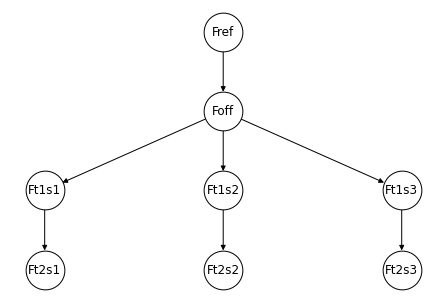

In [13]:
pos = graphviz_layout(G, prog="dot")
networkx.draw(G, pos, arrows=True,node_color='w', edgecolors='k',node_size=1500, with_labels = True)
plt.show()

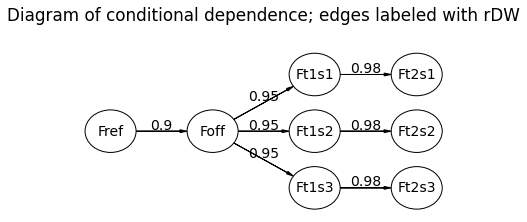

In [14]:
pgm = draw_tree.prepare_tree_pgm(nodes, edges, node_labels, rdw, root)
pgm.render()
plt.title(f"Diagram of conditional dependence; edges labeled with rDW\n")
plt.show()

### Distributions on trees
**Note:** This section is not essential--it just provides a benchmark for the "Rice-product-priors" section.

#### Covariance matrix for a gaussian tree
Murphy, section 10.2.5 provides an algorithm for calculating the covariance matrix of a Gaussian tree. Let's check it!

In [15]:
# to avoid renaming...
list_of_rdw   = rdw
list_of_edges = edges
list_of_nodes = nodes
n_nodes       = 8
n_edges       = len(list_of_rdw)

# The following implements Murphy, eqs. 10.15-10.22
# W_ts = rdw if edge s -> t
W = np.zeros((n_nodes, n_nodes))
S = np.zeros((n_nodes, n_nodes))
for i in range(n_edges):
    W[list_of_edges[i][1], list_of_edges[i][0]] = list_of_rdw[i]

S[0,0]=np.sqrt(0.5) # this is not explicit in Murphy but essential
for i in range(n_edges):
    S[list_of_edges[i][1],list_of_edges[i][1]] = np.sqrt(0.5*(1-list_of_rdw[i]**2))

U = np.linalg.inv(np.eye(n_nodes)-W)
Sig_DAG = np.matmul(np.matmul(U,S),np.transpose(np.matmul(U,S)))

# for this example, I worked the matrix out by hand as well:
Sig_full = [[1,r,r*rx,r*rx*rt,r*rx,r*rx*rt,r*rx,r*rx*rt],\
            [r,1,rx,rx*rt,rx,rx*rt,rx,rx*rt],\
            [rx*r,rx,1,rt,rx*rx,rx*rx*rt,rx*rx,rx*rx*rt],\
            [rt*rx*r,rt*rx,rt,1,rt*rx*rx,rt*rx*rx*rt,rt*rx*rx,rt*rx*rx*rt],\
            [rx*r,rx,rx*rx,rx*rx*rt,1,rt,rx*rx,rx*rx*rt],\
            [rt*rx*r,rt*rx,rt*rx*rx,rt*rx*rx*rt,rt,1,rt*rx*rx,rt*rx*rx*rt],\
            [rx*r,rx,rx*rx,rx*rx*rt,rx*rx,rx*rx*rt,1,rt],\
            [rt*rx*r,rt*rx,rt*rx*rx,rt*rx*rx*rt,rt*rx*rx,rt*rx*rx*rt,rt,1]
           ]
Sig_full = 0.5*np.array(Sig_full)

print("By hand...")
print(np.array2string(Sig_full,precision=3))
print('\n And now by Murphy\'s eqns:')
print(np.array2string(Sig_DAG,precision=3))
# plt.imshow(Sig_full-Sig_DAG)
# plt.title(r"$\Delta$Cov (by hand - Murphy)",fontsize=12)
# plt.colorbar()
# plt.show()

By hand...
[[0.5   0.45  0.427 0.419 0.427 0.419 0.427 0.419]
 [0.45  0.5   0.475 0.465 0.475 0.465 0.475 0.465]
 [0.427 0.475 0.5   0.49  0.451 0.442 0.451 0.442]
 [0.419 0.465 0.49  0.5   0.442 0.433 0.442 0.433]
 [0.427 0.475 0.451 0.442 0.5   0.49  0.451 0.442]
 [0.419 0.465 0.442 0.433 0.49  0.5   0.442 0.433]
 [0.427 0.475 0.451 0.442 0.451 0.442 0.5   0.49 ]
 [0.419 0.465 0.442 0.433 0.442 0.433 0.49  0.5  ]]

 And now by Murphy's eqns:
[[0.5   0.45  0.428 0.419 0.428 0.419 0.428 0.419]
 [0.45  0.5   0.475 0.466 0.475 0.466 0.475 0.466]
 [0.428 0.475 0.5   0.49  0.451 0.442 0.451 0.442]
 [0.419 0.466 0.49  0.5   0.442 0.433 0.442 0.433]
 [0.428 0.475 0.451 0.442 0.5   0.49  0.451 0.442]
 [0.419 0.466 0.442 0.433 0.49  0.5   0.442 0.433]
 [0.428 0.475 0.451 0.442 0.451 0.442 0.5   0.49 ]
 [0.419 0.466 0.442 0.433 0.442 0.433 0.49  0.5  ]]


Let's implement these as functions

In [16]:
def Cov_from_DAG_acentric(list_of_nodes, list_of_edges, list_of_rdw, mu_per_node=0, Sigma=1, as_block=True):
    '''
    Calculating the covariance of the JPD of a directed acyclic graph of acentric structure factors.
    This implements Murphy, eqs. 10.15-10.22
    Input arguments:
    list_of_nodes : List of indices of nodes to be used in calculating the JPD
    list_of_edges : List of tuples (from, to) summarizing conditional dependencies
    list_of_rdw   : List of double-wilson parameters (floats) corresponding to each edge
    mu_per_node   : List of floats; unconditional expectation values for each node (default: 0)
    Sigma         : Float, default expectation value <F**2> (Default: 1)
    as_block      : Boolean; whether to return a block matrix with covariances for real and 
                    imaginary components (Default: True).
    '''
    n_nodes = len(list_of_nodes)
    n_edges = len(list_of_edges)

    W = np.zeros((n_nodes, n_nodes))
    S = np.zeros((n_nodes, n_nodes))
    for i in range(n_edges):
        W[list_of_edges[i][1], list_of_edges[i][0]] = list_of_rdw[i]

    S[0,0]=np.sqrt(0.5*Sigma) # this is not explicit in Murphy but essential
    for i in range(n_edges):
        S[list_of_edges[i][1],list_of_edges[i][1]] = np.sqrt(0.5*(1-list_of_rdw[i]**2))

    U = np.linalg.inv(np.eye(n_nodes)-W)
    Sig_DAG = np.matmul(np.matmul(U,S),np.transpose(np.matmul(U,S)))
    
    if as_block:
        return np.block([[Sig_DAG,np.zeros((n_nodes,n_nodes))],[np.zeros((n_nodes,n_nodes)),Sig_DAG]])
    else:
        return Sig_DAG

def Cov_from_DAG_centric( list_of_nodes, list_of_edges, list_of_rdw, mu_per_node=0, Sigma=1):
    '''
    Calculating the covariance of the JPD of a directed acyclic graph of acentric structure factors.
    This implements Murphy, eqs. 10.15-10.22
    Input arguments:
    list_of_nodes : List of indices of nodes to be used in calculating the JPD
    list_of_edges : List of tuples (from, to) summarizing conditional dependencies
    list_of_rdw   : List of double-wilson parameters (floats) corresponding to each edge
    mu_per_node   : List of floats; unconditional expectation values for each node (default: 0)
    Sigma         : Float, default expectation value <F**2> (Default: 1)
    '''
    return Cov_from_DAG_acentric(list_of_nodes, list_of_edges, list_of_rdw, mu_per_node, Sigma=2*Sigma, as_block=False)

In [17]:
print(np.array2string(Cov_from_DAG_acentric(list_of_nodes, list_of_edges, list_of_rdw, mu_per_node=0, as_block=False),\
                      precision=3))

[[0.5   0.45  0.428 0.419 0.428 0.419 0.428 0.419]
 [0.45  0.5   0.475 0.466 0.475 0.466 0.475 0.466]
 [0.428 0.475 0.5   0.49  0.451 0.442 0.451 0.442]
 [0.419 0.466 0.49  0.5   0.442 0.433 0.442 0.433]
 [0.428 0.475 0.451 0.442 0.5   0.49  0.451 0.442]
 [0.419 0.466 0.442 0.433 0.49  0.5   0.442 0.433]
 [0.428 0.475 0.451 0.442 0.451 0.442 0.5   0.49 ]
 [0.419 0.466 0.442 0.433 0.442 0.433 0.49  0.5  ]]


We could sample from the full joint PDF or condition on, for example, the $F^{ref}$.

In [18]:
# For conditioning on multiple nodes, the equations needs some adjustment--see Wikipedia
Eref=1.5
Sig_cond  = Sig_full[1:n_nodes,1:]-np.matmul(Sig_full[1:,0].reshape(-1,1),Sig_full[0,1:].reshape(1,-1))/Sig_full[0,0]
mean_cond = np.matmul(Sig_full[1:,0].reshape(-1,1),np.linalg.inv(Sig_full[0,0].reshape(1,-1)))*Eref
# print(mean_cond)

#### Sampling from the unconditional MVN of the DAG for acentrics
We'll specialize right away to all unconditional means = 0; since that is the only case that matters as far as I can tell. Otherwise, see Murphy and Wikipedia on MVN provide all the information needed for more complete expressions.

In [19]:
# Unconditional (each marginal distribution should be a Wilson distribution):
mu_full = np.zeros((2*n_nodes,))
Cov_from_DAG_acentric_full = Cov_from_DAG_acentric(list_of_nodes, list_of_edges, list_of_rdw, as_block=True)

# Conditional on an observation for F_ref (node 0):
S                          = Cov_from_DAG_acentric(list_of_nodes, list_of_edges, list_of_rdw, as_block=False)
S_cond =  S[1:n_nodes,1:]-np.matmul(S[1:,0].reshape(-1,1),S[0,1:].reshape(1,-1))/S[0,0]
Cov_from_DAG_acentric_cond = np.block([[S_cond, np.zeros((n_nodes-1,n_nodes-1))],\
                                       [np.zeros((n_nodes-1,n_nodes-1)), S_cond]])
E0 = 1.5 # value of 0th structure factor amplitude that we're conditioning on
         # we will assume that phi(0) = 0 without loss of generality
mu_cond = np.block([np.matmul(S[1:,0].reshape(-1,1),np.linalg.inv(S[0,0].reshape(1,-1)))*E0,\
                    np.matmul(S[1:,0].reshape(-1,1),np.linalg.inv(S[0,0].reshape(1,-1)))*0]).ravel('F')
if False:
    plt.figure(figsize=(10,4.2))                         
    plt.subplot(1,2,1)  
    plt.imshow(Cov_from_DAG_acentric_full)
    plt.title("Cov_from_DAG_acentric_full")
    plt.subplot(1,2,2)  
    plt.imshow(Cov_from_DAG_acentric_cond)
    plt.title("Cov_from_DAG_acentric_cond")
    plt.show() # graphical check

Unconditional:

In [20]:
n_samples = 1000000
vals = rng.multivariate_normal(mu_full,Cov_from_DAG_acentric_full,n_samples)

phi   = np.zeros((n_samples, n_nodes))
R_sq  = np.zeros((n_samples, n_nodes))
R_abs = np.zeros((n_samples, n_nodes))
for i in range(n_nodes):
    phi[  :,i] = np.angle(vals[:,i] + 1j*vals[:,n_nodes+i])
    R_sq[ :,i] = vals[:,i]**2 + vals[:,n_nodes+i]**2
    R_abs[:,i] = np.abs(vals[:,i] + 1j*vals[:,n_nodes+i])

#### Sampling from the conditional MVN of the DAG for acentrics
Conditional on $E_0$:

In [21]:
n_samples = 1000000
n_nodes_cond = n_nodes-1
vals = rng.multivariate_normal(mu_cond,Cov_from_DAG_acentric_cond,n_samples)

phi_cond   = np.zeros((n_samples, n_nodes_cond))
R_sq_cond  = np.zeros((n_samples, n_nodes_cond))
R_abs_cond = np.zeros((n_samples, n_nodes_cond))
for i in range(n_nodes-1):
    phi_cond[  :,i] = np.angle(vals[:,i]    + 1j*vals[:,n_nodes_cond+i])
    R_sq_cond[ :,i] =          vals[:,i]**2 +    vals[:,n_nodes_cond+i]**2
    R_abs_cond[:,i] = np.abs(  vals[:,i]    + 1j*vals[:,n_nodes_cond+i])

### Factorizing the joint probability for SF amplitudes on trees

As we saw in "_Factorizing the joint probability_" for the bivariate case, the results of _both_ integrals are Rice distributions. The above principle generalizes to directed trees. Let's mark the parent of each node $R_i$ as $\mathrm{Pa}(R_i)$; let the "origin" be $R_0$, and refer to the DW parameter for $P\left(R_i \bigr| \mathrm{Pa}(R_i)\right)$ as $r_i$, then,

$$
P\left(R_i \bigr| \mathrm{Pa}(R_i)\right) = \int d\Delta\phi_{i,\mathrm{Pa}(i)} P\left(R_i,\Delta\phi_{i,\mathrm{Pa(i)}}\bigr| \mathrm{Pa}(R_i)\right) = Rice\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \frac{\Sigma}{2}(1-r_i^2)\right)
$$
and

$$
P\left(\{R_i: \ i>0\} \bigr| R_0\right) = \prod_{i>0} Rice\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \frac{\Sigma}{2}(1-r_i^2)\right)
$$

That is, to specify a joint prior, all we need to do is to specify the reference prior (optional!), the tree structure $\left\{\left(i, \mathrm{Pa}(i)\right)\right\}$, and estimates of the $r_i$. In the limit of $r_i\rightarrow 0$, the priors return to the Wilson distribution. 

#### Centric case:
$$
P\left(R_i \bigr| \mathrm{Pa}(R_i)\right) = \int d\Delta\phi_{i,\mathrm{Pa}(i)} P\left(R_i,\Delta\phi_{i,\mathrm{Pa(i)}}\bigr| \mathrm{Pa}(R_i)\right) = \mathrm{FoldedNormal}\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \Sigma(1-r_i^2)\right)
$$
and

$$
P\left(\{R_i: \ i>0\} \bigr| R_0\right) = \prod_{i>0} \mathrm{FoldedNormal}\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \Sigma(1-r_i^2)\right)
$$

**!** I implemented these joint probability distributions in ```dag_pgm_tools.RiceWoolfson_for_DAG```, along with methods for sampling from them.

#### Sampling using the "Rice-product priors"

I implemented the priors on structure factor amplitudes for arbitrary DAGs (or trees, rather) in ```dw_tools/dag_pgm_tools.py```. I freely pirated from Careless to facilitate implementation there. This implementation uses the ```scipy.stats``` parametrization of the Rice and Folded Normal distributions. Code should be cleaner when using $\nu$ and $\sigma^2$. See ```5_Parsing_DW_parameters``` for details on parsing parameters for Rice and Folded Normal.

In [22]:
# a test for the PDF calculation for a single edge
daughter_dist=dag_pgm_tools.RiceWoolfson_from_parent(parent_R=np.array([1,1.5,2]), rDW=np.array([0.2,0.4,0.8]), \
                                                     Sigma=1, centric=False)
print(daughter_dist.mean())
print(daughter_dist.variance())
print(daughter_dist.stddev)
print(daughter_dist.sample((3,)))
# print(daughter_dist.log_prob(np.linspace(0,4,10)))
# print(daughter_dist.prob(np.linspace(0,4,10)))

[0.88631797 0.97759167 1.65738242]
[0.21444046 0.24431452 0.17308353]
<bound method RiceWoolfson_from_parent.stddev of <dw_tools.dag_pgm_tools.RiceWoolfson_from_parent object at 0x000001BC86075C70>>
[0.47028652 0.74750429 0.76659217]


In [23]:
# a test for the PDF calculation for the entire graph
tmp=dag_pgm_tools.RiceWoolfson_for_DAG(list_of_nodes, list_of_edges, root, list_of_rdw, \
                         root_R=np.array([1.5,3]), root_rDW=list_of_rdw[0], Sigma=1, centric=False)
my_samples = tmp.sample(1000000)

if False:
    refl_id = 0
    plt.figure(figsize=(13,11))                         
    for node_id in range(n_nodes):
        plt.subplot(3,3,node_id+1) 
        plt.hist(my_samples[node_id, refl_id,:].flatten(),100,density=True)
        plt.title(f"Node {node_id}")
        plt.xlim((0,4))
        plt.grid()
    plt.show()

#### Graphical comparison of sampling methods
We'll compare sampling from the multivariate normal for the graph and the "product-of-Rice" prior.

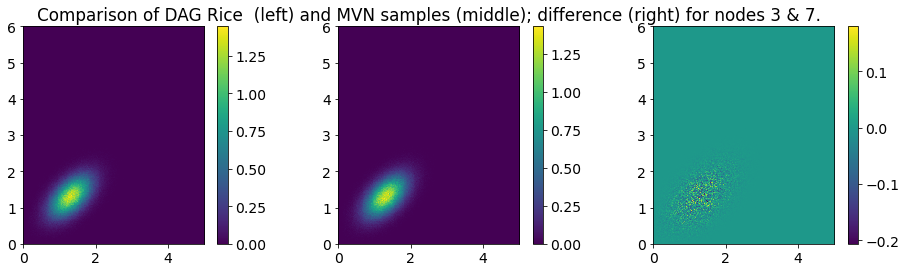

In [24]:
node_1  = 3
node_2  = 7
refl_id = 0
(xmax,ymax) = (x_max,y_max)
xedges = np.linspace(0,xmax,nx+1)
yedges = np.linspace(0,ymax,ny+1)
Hx_rice_samples, xedges, yedges = np.histogram2d(my_samples[node_1, refl_id,:].flatten(), \
                                                 my_samples[node_2, refl_id,:].flatten(), \
                                                 bins=(xedges, yedges),density=True)
Hx_mvn_samples,  xedges, yedges = np.histogram2d(R_abs_cond[:,node_1-1].flatten(), \
                                                 R_abs_cond[:,node_2-1].flatten(), \
                                                 bins=(xedges, yedges),density=True)

# Since the axes of these plots drive me a nuts, a positive control using [yplot.hist2d.
# In addition, I made the 2D histograms below asymmetric in dimension (remove "extent=[]" to see that),
# and validated labels using 1D histograms above.
# fig,ax=plt.subplots()
# ax.hist2d(R2_abs, R3_abs,bins=50,range=[[0,xmax],[0,ymax]])
# ax.set_aspect('equal')
# ax.set_xlabel(r"$R_2$"); ax.set_ylabel(r"$R_3$")
# plt.show()

plt.figure(figsize=(16,4))                         
plt.subplot(1,3,1)        
plt.imshow(Hx_rice_samples.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) 
plt.colorbar(); 

plt.subplot(1,3,2)        
plt.imshow(Hx_mvn_samples.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.colorbar()
plt.title("Comparison of DAG Rice  (left) and MVN samples (middle); difference (right) for nodes "\
          + str(node_1) + " & " +str(node_2) + ".")

plt.subplot(1,3,3)        
plt.imshow(Hx_mvn_samples.T - Hx_rice_samples.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.colorbar()
plt.show()

Looks pretty consistent!

## Sample applications

The general benefit of using a joint prior is that each data point contributes to accurate scaling of each other data point that it is related through by the tree--regardless of whether it is OFF or ON data, or which Friedel mate (anomalous), or through which sym op it relates to the OFF ASU. 

Below, some thoughts on how to set up different scaling problems.

### Merging HEWL anomalous data
For example, Laue anomalous data using NE-CAT IMEAN (which will serve as ```Fref```):

In [32]:
(r,)   = (0.98,)
node_labels   = ["Fref", "F(+)", "F(-)"]
nodes         = range(len(node_labels))
root          = 0 # root of the tree
edges         = [(0,1),(0,2)]
rdw           = [r,    r] 
edge_labels   = [(node_labels[edges[e][0]], node_labels[edges[e][1]]) for e in range(len(edges))]

G=networkx.DiGraph()
G.add_nodes_from(node_labels)                            
G.add_edges_from(edge_labels)
print(f"Is this a valid tree? {networkx.is_arborescence(G)}.")

Is this a valid tree? True.


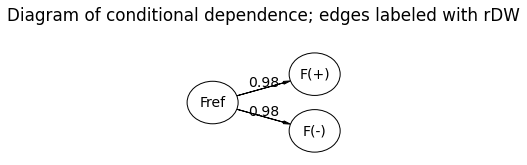

In [33]:
pgm = draw_tree.prepare_tree_pgm(nodes, edges, node_labels, rdw, root)
pgm.render()
plt.title(f"Diagram of conditional dependence; edges labeled with rDW\n")
plt.show()

### LCLS THz data
In this case, it is not really obvious that the 300fs timepoint would really be more different from OFF than the 0fs timepoint, so we have four arrows from OFF (two timepoints $(t_1,t_2)$ x two symops $(s_1,s_2)$).

In [58]:
(r, rx)   = (0.95, 0.98)
node_labels   = ["Fref", "Foff", "Ft1s1", "Ft2s1", "Ft1s2", "Ft2s2"]
nodes         = range(len(node_labels))
root          = 0 # root of the tree
# edges       = [(0,1),(1,2),(2,3),(1,4),(4,5)]
edges         = [(0,1),(1,2),(1,3),(1,4),(1,5)]
rdw           = [r,    rx,   rx,   rx,   rx] 
edge_labels   = [(node_labels[edges[e][0]], node_labels[edges[e][1]]) for e in range(len(edges))]

G=networkx.DiGraph()
G.add_nodes_from(node_labels)                            
G.add_edges_from(edge_labels)
print(f"Is this a valid tree? {networkx.is_arborescence(G)}.")

Is this a valid tree? True.


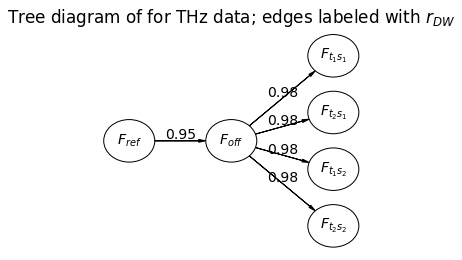

In [59]:
node_labels_fancy   = [r"$F_{ref}$",\
                       r"$F_{off}$",\
                       r"$F_{t_1s_1}$",\
                       r"$F_{t_2s_1}$",\
                       r"$F_{t_1s_2}$",\
                       r"$F_{t_2s_2}$"]

pgm = draw_tree.prepare_tree_pgm(nodes, edges, node_labels_fancy, rdw, root)
pgm.render()
plt.title(r"Tree diagram of for THz data; edges labeled with $r_{DW}$")
plt.show()

If we only use one timepoint, this reduces to:

In [41]:
node_labels   = ["Fref", "Foff", "Ft1s1", "Ft1s2"]
nodes         = range(len(node_labels))
root          = 0 # root of the tree
# edges       = [(0,1),(1,2),(2,3),(1,4),(4,5)]
edges         = [(0,1),(1,2),(1,3)]
rdw           = [r,    rx,   rx,  ] 
edge_labels   = [(node_labels[edges[e][0]], node_labels[edges[e][1]]) for e in range(len(edges))]

G=networkx.DiGraph()
G.add_nodes_from(node_labels)                            
G.add_edges_from(edge_labels)
print(f"Is this a valid tree? {networkx.is_arborescence(G)}.")

Is this a valid tree? True.


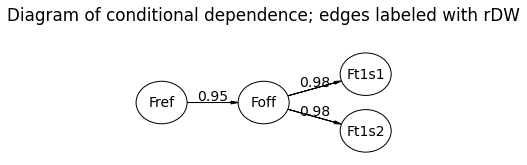

In [42]:
pgm = draw_tree.prepare_tree_pgm(nodes, edges, node_labels, rdw, root)
pgm.render()
plt.title(f"Diagram of conditional dependence; edges labeled with rDW\n")
plt.show()

### Typical time-resolved data
Shown without reference data. Those can be added at the root.
For DHFR, going to ```P 21 1 1```, the ASU doubles in size, which shows up here as two branches coming out of $F^{off}$. Going to ```P 1``` would yield four branches coming out of $F^{off}$. For ```P31 2 1```, there could even be six branches. That is, in a way, the point: by tying them together, we can more effectively condition scaling than by treating independently data diluted by symmetry breaking.

In [55]:
(r, rx)       = (0.95, 0.98)
node_labels   = ["Foff", "Ft1s1", "Ft2s1", "Ft3s1", "Ft1s2", "Ft2s2", "Ft3s2"]
nodes         = range(len(node_labels))
root          = 0 # root of the tree
edges         = [(0,1),(1,2),(2,3),(0,4),(4,5),(5,6)]
rdw           = [r    , rx  , rx  , r   , rx  , rx  ] 
edge_labels   = [(node_labels[edges[e][0]], node_labels[edges[e][1]]) for e in range(len(edges))]

G=networkx.DiGraph()
G.add_nodes_from(node_labels)                            
G.add_edges_from(edge_labels)
print(f"Is this a valid tree? {networkx.is_arborescence(G)}.")

Is this a valid tree? True.


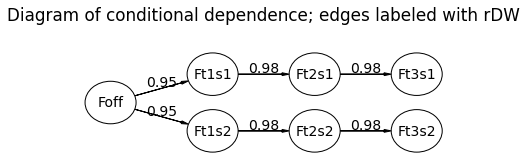

In [56]:
pgm = draw_tree.prepare_tree_pgm(nodes, edges, node_labels, rdw, root)
pgm.render()
plt.title(f"Diagram of conditional dependence; edges labeled with rDW\n")
plt.show()

### Practical considerations
1. In the case where different branches of the tree represent application of different symops to the OFF _hkl_, each branch retains the number of reflections of the OFF spacegroup. To facilitate this, we need to "unstack" the reflections in the lower-symmetry space group to match the rows of the OFF dataset (analogous to ```unstack_anomalous()```). This is the inverse of the operation done when expanding, e.g., the refined GFP P21 21 21 map coefficients to P21 (analogous to ```expand_anomalous()```). The easiest way of doing this is probably to keep track of the operations used to go to the lower symmetry space group in the first place--I assume this can be done using ```M/ISYM``` column.


2. Some reflections are invariant under the stacking symmetry operations (analogous to centrics)--they can be retained as replicate copies but all but one column will need to be masked in the log_prob calculation.


3. In the examples below, I use scalar $r_{DW}$. Note that ```dag_pgm_tools.RiceWoolfson_from_parent``` accepts a list of $r_{DW}$ (one per graph edge)--each list element can be a scalar or have the same number of entries at there are rows in the joined reflection dataset/numpy array.


4. $\Sigma$ can, likewise, be a scalar or an array with number of rows matching the OFF data set.


5. If one uses an external reference data set, it **must** already be normalized, or otherwise live on the scale of $\Sigma$, e.g. by first passing the reference data through (some of) **1_Dataset_prep_and_local_scaling** for normalization. To assign a single $r_{DW}$ per reflection to the reference data, follow sections 1.3 of **3_Fitting_DW_to_paired_data**.